In [2]:
!pip install -q kaggle

In [3]:
!pip install tqdm

In [4]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 94% 312M/331M [00:01<00:00, 219MB/s]
100% 331M/331M [00:01<00:00, 203MB/s]


In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from tqdm.notebook import tqdm

In [6]:
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [7]:
!unzip *.zip && rm -rf *.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [8]:
DIRECTORY = "/content/UTKFace/"

In [9]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(DIRECTORY )):
    image_path = os.path.join(DIRECTORY , filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [10]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [11]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/UTKFace/7_1_4_20170104010111013.jpg.c...,7,1
1,/content/UTKFace/35_0_2_20170116181159415.jpg....,35,0
2,/content/UTKFace/53_0_0_20170117161103166.jpg....,53,0
3,/content/UTKFace/90_0_2_20170111223901221.jpg....,90,0
4,/content/UTKFace/65_1_1_20170117184041200.jpg....,65,1


In [12]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

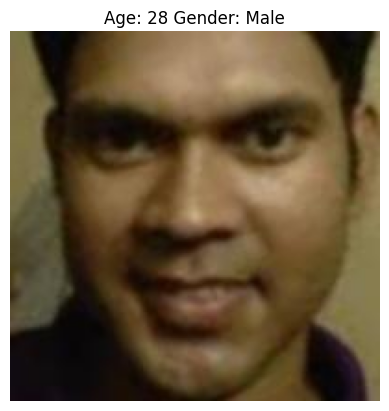

In [13]:
from PIL import Image
import random
rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

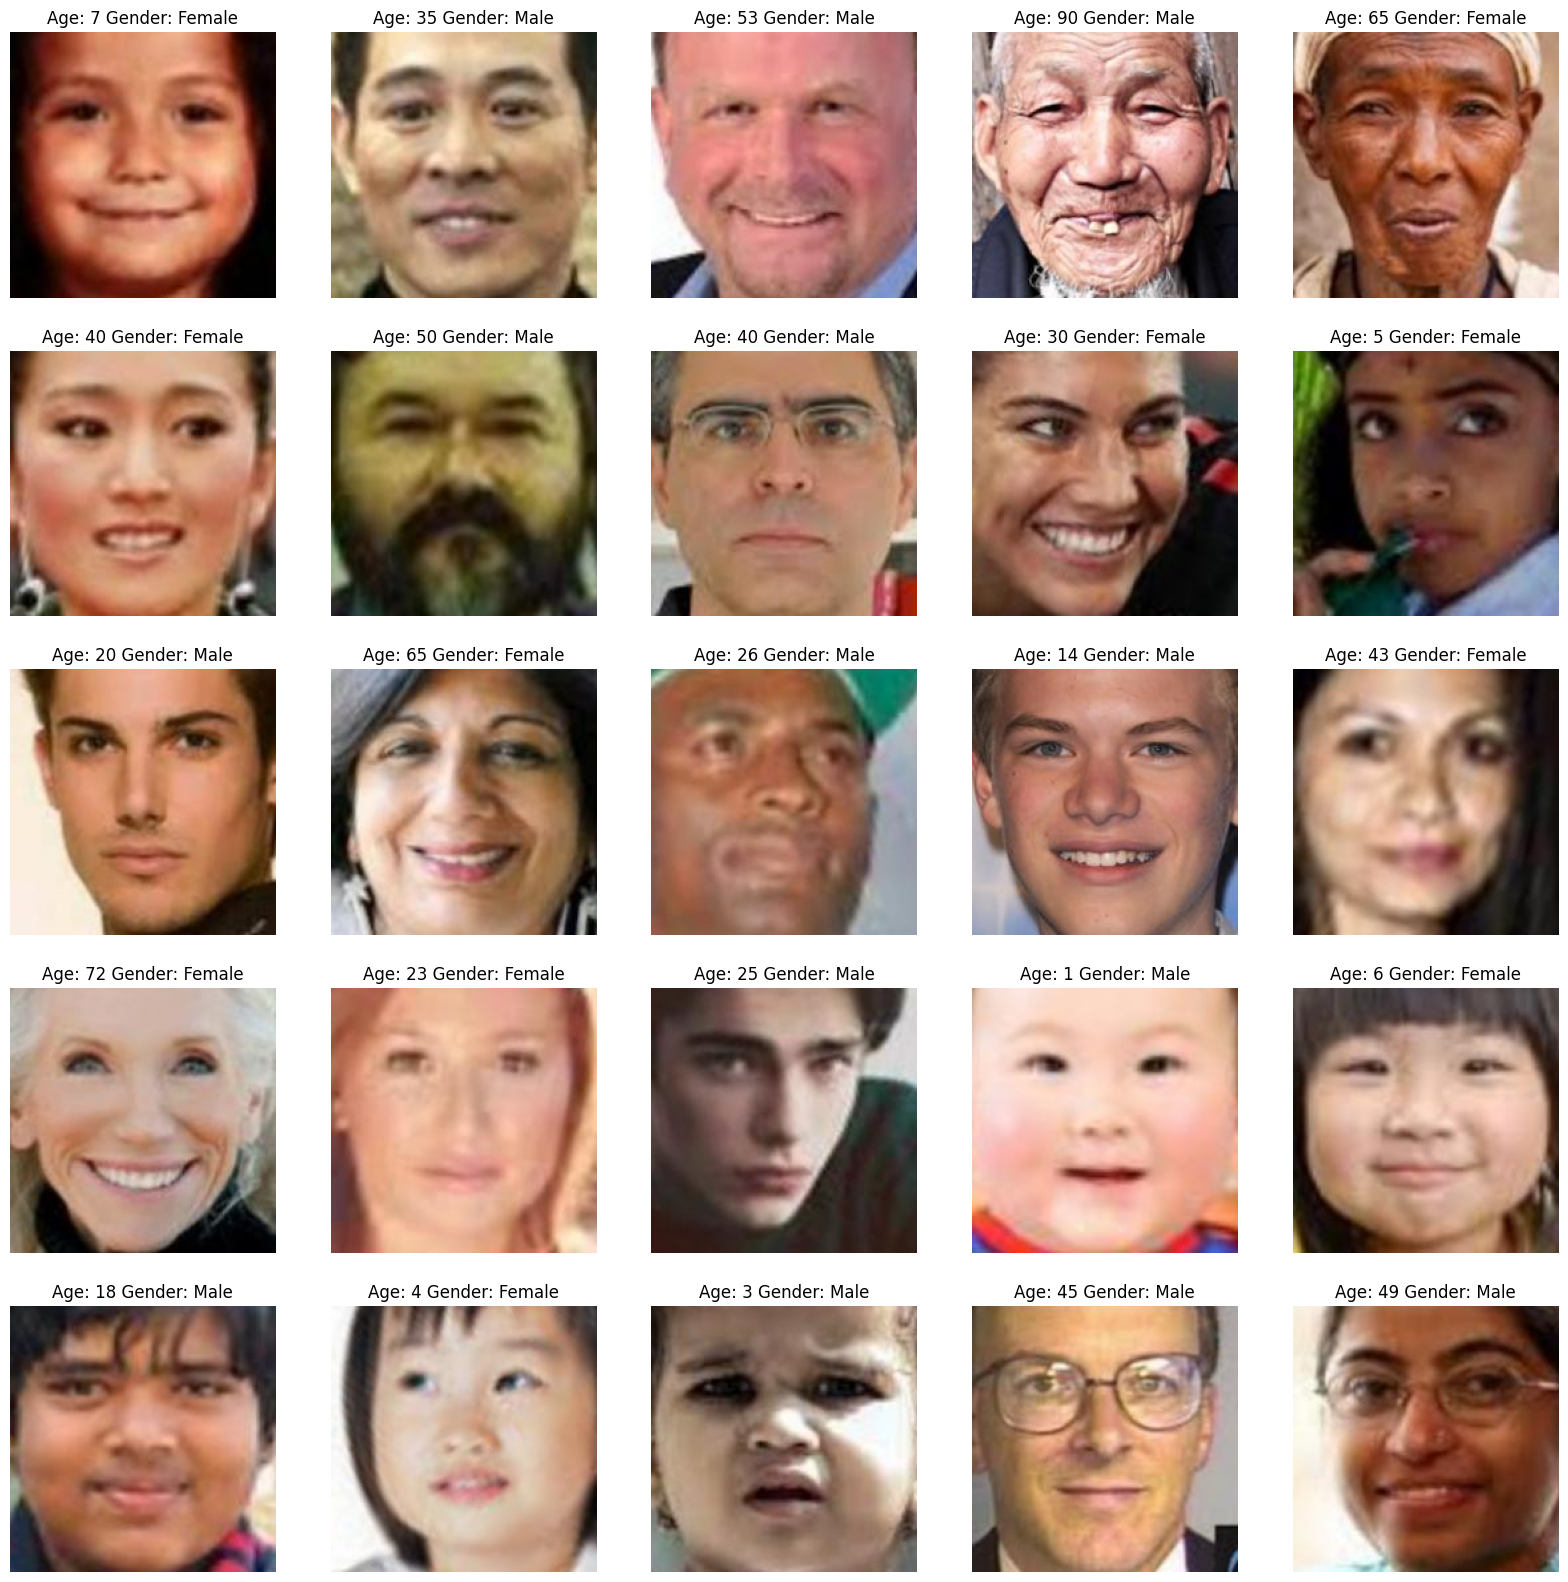

In [14]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_mapping[gender]}")
    plt.axis('off')

In [15]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,color_mode='grayscale')
        img = img.resize((128, 128),  Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [16]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [17]:
X.shape

(23708, 128, 128, 1)

In [18]:
# normalize the images
X = X/255.0

In [19]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [20]:
input_shape = (128, 128, 1)

In [21]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=[['accuracy'], ['mae']])

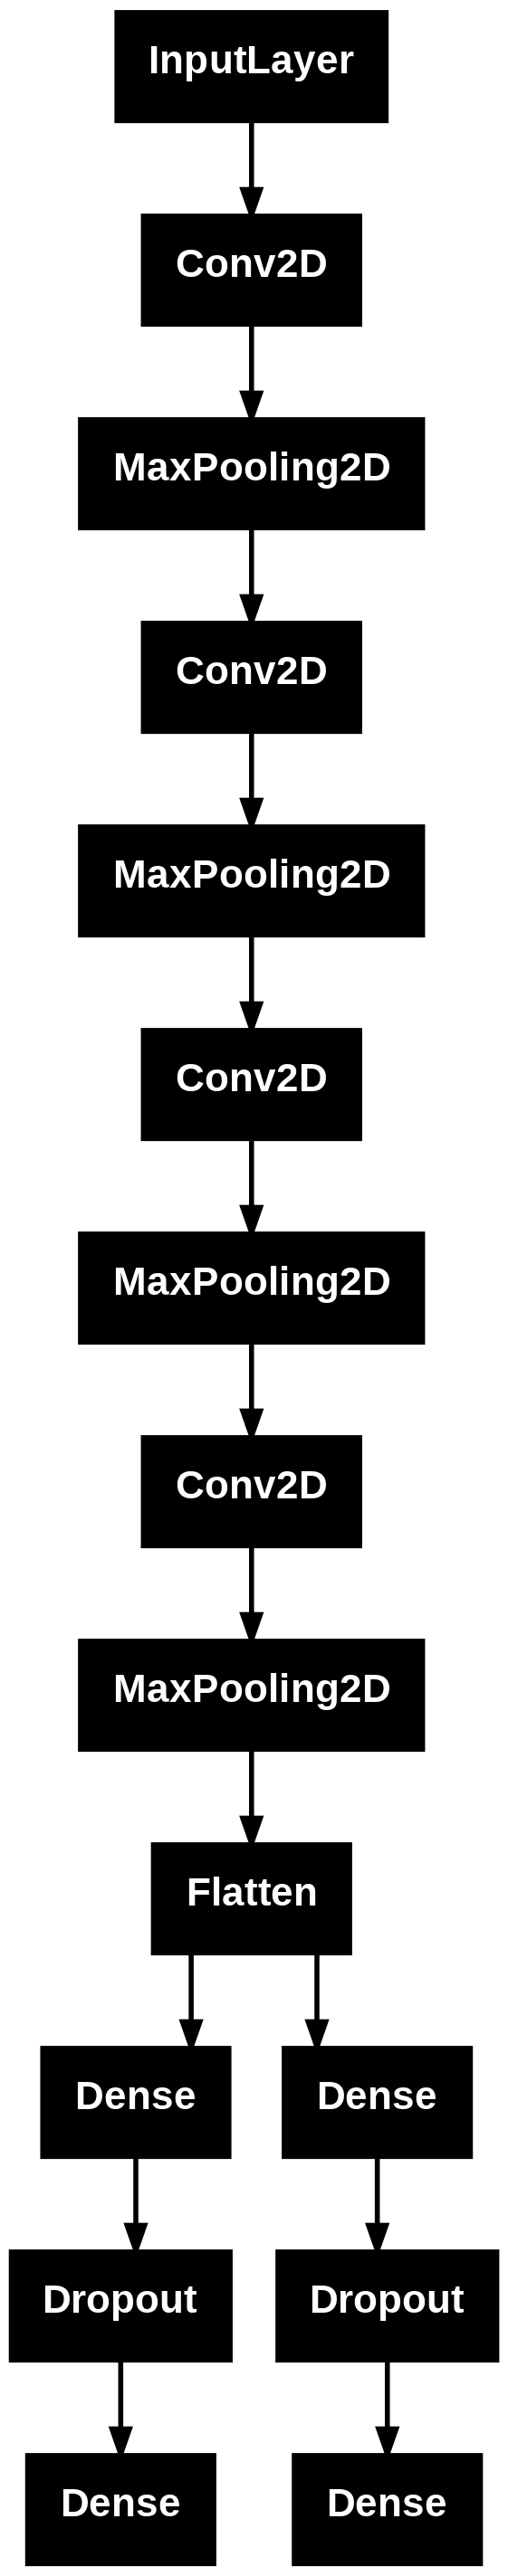

In [22]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [23]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2, verbose=1)

Epoch 1/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - age_out_mae: 17.0385 - gender_out_accuracy: 0.5174 - loss: 17.7561 - val_age_out_mae: 12.2871 - val_gender_out_accuracy: 0.7134 - val_loss: 12.8564
Epoch 2/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - age_out_mae: 11.7806 - gender_out_accuracy: 0.7375 - loss: 12.3101 - val_age_out_mae: 9.5104 - val_gender_out_accuracy: 0.7910 - val_loss: 9.9535
Epoch 3/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - age_out_mae: 9.6665 - gender_out_accuracy: 0.7979 - loss: 10.1021 - val_age_out_mae: 8.6342 - val_gender_out_accuracy: 0.8292 - val_loss: 9.0075
Epoch 4/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - age_out_mae: 8.7763 - gender_out_accuracy: 0.8274 - loss: 9.1584 - val_age_out_mae: 7.7098 - val_gender_out_accuracy: 0.8368 - val_loss: 8.0625
Epoch 5/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - age_out_mae: 7.8667 - gender_out_accuracy: 0.8476 - loss: 8.1966 - val_age_out_mae: 8.0965 - val_gender_out_accuracy: 0.8646 - val_loss: 

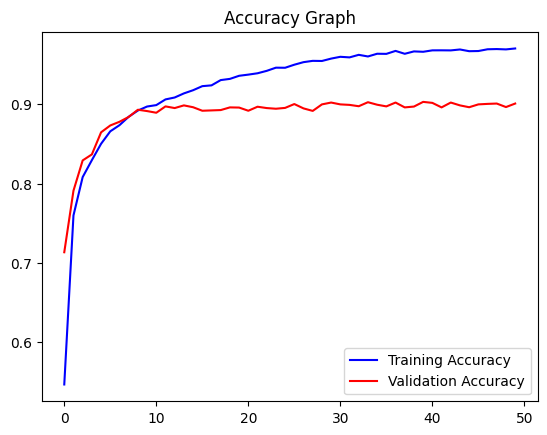

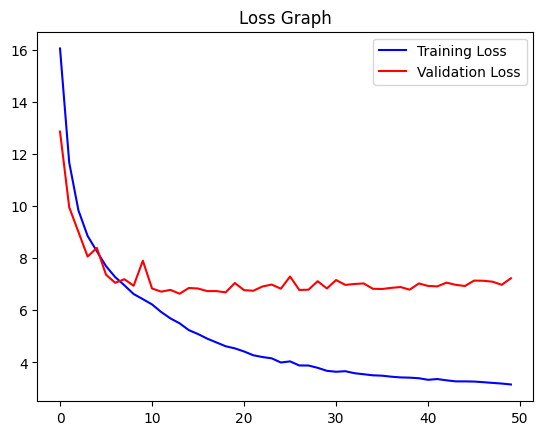

In [25]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

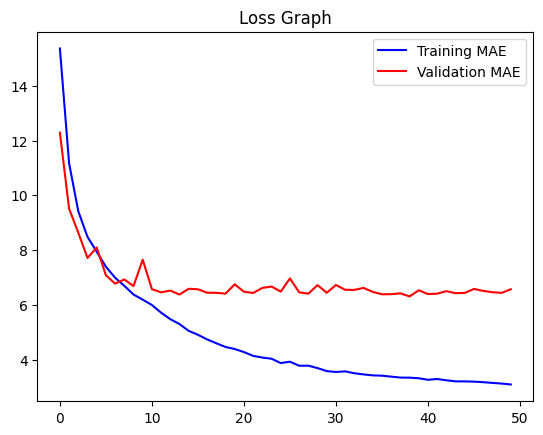

In [27]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 36
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
Predicted Gender: Male Predicted Age: 39


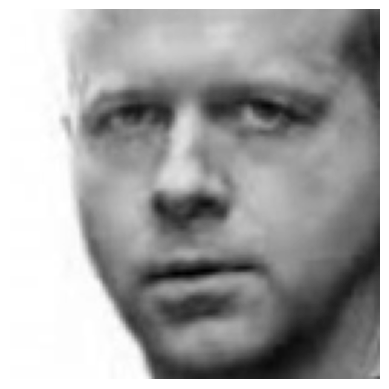

In [28]:
image_index = 100
print("Original Gender:", gender_mapping[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_mapping[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 34
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Gender: Female Predicted Age: 31


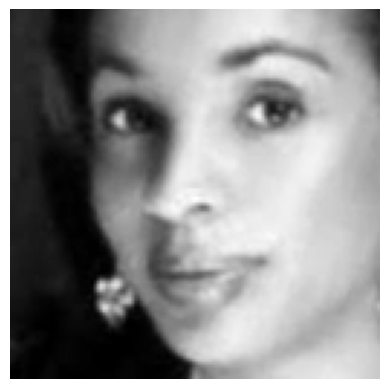

In [29]:
image_index = 3000
print("Original Gender:", gender_mapping[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_mapping[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');